In [2]:
import os
import math
import sqlite3

import numpy as np
import pandas as pd

db_path = os.path.join(os.path.dirname("__file__"), "..", "..", "data", "ufc.db")

In [3]:
query = """
WITH cte1 AS (
    SELECT
        event_id,
        MAX(name) AS event_name,
        t2.date,
        MAX(t3.wikipedia_id) AS event_order,
        COUNT(CASE WHEN red_outcome = 'W' THEN 1 END) AS red_wins,
        COUNT(CASE WHEN red_outcome = 'L' THEN 1 END) AS red_losses
    FROM ufcstats_bouts AS t1
    LEFT JOIN ufcstats_events AS t2
    ON t1.event_id = t2.id
    INNER JOIN event_mapping AS t3
    ON t1.event_id = t3.ufcstats_id
    WHERE t2.is_ufc_event = 1
    GROUP BY event_id
    ORDER BY event_order
),
cte2 AS (
    SELECT
        t1.event_id,
        t1.date,
        t4.latitude,
        t4.longitude,
        t4.elevation_meters,
        AVG(t3.attendance) OVER(
            PARTITION BY t3.venue_id
            ORDER BY t1.event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS avg_venue_attendance,
        t4.capacity AS venue_capacity,
        AVG(1.0 * t3.attendance / t4.capacity) OVER(
            PARTITION BY t3.venue_id
            ORDER BY t1.event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS avg_venue_occupancy_pct,
        AVG(1.0 * t3.attendance / t4.capacity) OVER(
            ORDER BY t1.event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS avg_occupancy_pct,
        t1.event_order,
        t1.red_wins,
        t1.red_losses,
        CASE
            WHEN t1.event_name LIKE 'UFC %' AND t1.event_name GLOB 'UFC [0-9]*' THEN 1
            ELSE 0
        END AS is_ppv,
        t3.venue_id,
        t5.country,
        strftime('%Y', t6.date) AS year,
        strftime('%m', t6.date) AS month,
        t6.hour_utc AS start_hour_utc
    FROM cte1 AS t1
    LEFT JOIN event_mapping AS t2
    ON t1.event_id = t2.ufcstats_id
    LEFT JOIN wikipedia_events AS t3
    ON t2.wikipedia_id = t3.id
    LEFT JOIN wikipedia_venues AS t4
    ON t3.venue_id = t4.id
    LEFT JOIN fightmatrix_events AS t5
    ON t2.fightmatrix_id = t5.id
    LEFT JOIN espn_events AS t6
    ON t2.espn_id = t6.id
),
cte3 AS (
    SELECT
        event_id,
        latitude,
        longitude,
        elevation_meters,
        CASE
            WHEN avg_venue_attendance IS NULL THEN avg_occupancy_pct * venue_capacity
            ELSE avg_venue_attendance
        END AS avg_venue_attendance,
        venue_capacity,
        CASE
            WHEN avg_venue_occupancy_pct IS NULL THEN avg_occupancy_pct
            ELSE avg_venue_occupancy_pct
        END AS avg_venue_occupancy_pct,
        event_order,
        SUM(red_wins) OVER(
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_wins_cumsum,
        SUM(red_losses) OVER(
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_losses_cumsum,
        is_ppv,
        SUM(red_wins) OVER (
            PARTITION BY is_ppv
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_wins_cumsum_ppv_type,
        SUM(red_losses) OVER (
            PARTITION BY is_ppv
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_losses_cumsum_ppv_type,
        SUM(red_wins) OVER(
            PARTITION BY venue_id
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_wins_cumsum_venue,
        SUM(red_losses) OVER(
            PARTITION BY venue_id
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_losses_cumsum_venue,
        SUM(red_wins) OVER(
            PARTITION BY country
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_wins_cumsum_country,
        SUM(red_losses) OVER(
            PARTITION BY country
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_losses_cumsum_country,
        SUM(red_wins) OVER(
            PARTITION BY year
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_wins_cumsum_year,
        SUM(red_losses) OVER(
            PARTITION BY year
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_losses_cumsum_year,
        SUM(red_wins) OVER(
            PARTITION BY year, month
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_wins_cumsum_month,
        SUM(red_losses) OVER(
            PARTITION BY year, month
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_losses_cumsum_month,
        SUM(red_wins) OVER(
            PARTITION BY year, month
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_wins_cumsum_year_month,
        SUM(red_losses) OVER(
            PARTITION BY year, month
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_losses_cumsum_year_month,
        SUM(red_wins) OVER(
            PARTITION BY start_hour_utc
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_wins_cumsum_start_hour,
        SUM(red_losses) OVER(
            PARTITION BY start_hour_utc
            ORDER BY event_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS red_losses_cumsum_start_hour
    FROM cte2 AS t1
    WHERE t1.date >= '2008-04-19'
),
cte4 AS (
    SELECT
        event_id,
        latitude,
        longitude,
        elevation_meters,
        avg_venue_attendance,
        venue_capacity,
        avg_venue_occupancy_pct,
        LOG(1.0 * (IFNULL(red_wins_cumsum, 0) + 0.0001) / (IFNULL(red_losses_cumsum, 0) + 0.0001)) AS woe_overall,
        is_ppv,
        LOG(
            1.0 * (IFNULL(red_wins_cumsum_ppv_type, 0) + 0.0001) / (IFNULL(red_losses_cumsum_ppv_type, 0) + 0.0001)
        ) AS woe_by_ppv_type,
        LOG(
            1.0 * (IFNULL(red_wins_cumsum_venue, 0) + 0.0001) / (IFNULL(red_losses_cumsum_venue, 0) + 0.0001)
        ) AS woe_by_venue,
        LOG(
            1.0 * (IFNULL(red_wins_cumsum_country, 0) + 0.0001) / (IFNULL(red_losses_cumsum_country, 0) + 0.0001)
        ) AS woe_by_country,
        LOG(
            1.0 * (IFNULL(red_wins_cumsum_year, 0) + 0.0001) / (IFNULL(red_losses_cumsum_year, 0) + 0.0001)
        ) AS woe_by_year,
        LOG(
            1.0 * (IFNULL(red_wins_cumsum_month, 0) + 0.0001) / (IFNULL(red_losses_cumsum_month, 0) + 0.0001)
        ) AS woe_by_month,
        LOG(
            1.0 * (IFNULL(red_wins_cumsum_year_month, 0) + 0.0001) / (IFNULL(red_losses_cumsum_year_month, 0) + 0.0001)
        ) AS woe_by_year_month,
        LOG(
            1.0 * (IFNULL(red_wins_cumsum_start_hour, 0) + 0.0001) / (IFNULL(red_losses_cumsum_start_hour, 0) + 0.0001)
        ) AS woe_by_start_hour
    FROM cte3
)
SELECT
    t1.id,
    latitude,
    longitude,
    elevation_meters,
    avg_venue_attendance,
    venue_capacity,
    avg_venue_occupancy_pct,
    woe_overall,
    is_ppv,
    woe_by_ppv_type,
    woe_by_venue,
    woe_by_country,
    woe_by_year,
    woe_by_month,
    woe_by_year_month,
    woe_by_start_hour,
    CASE
        WHEN red_outcome = 'W' THEN 1
        ELSE 0
    END AS red_win
FROM ufcstats_bouts AS t1
LEFT JOIN cte4 AS t2
ON t1.event_id = t2.event_id
WHERE t1.event_id IN (
    SELECT id FROM ufcstats_events
    WHERE is_ufc_event = 1 AND date >= '2008-04-19'
) AND red_outcome IN ('W', 'L')
"""

with sqlite3.connect(db_path) as conn:
    conn.create_function("LOG", 1, math.log)
    df = pd.read_sql(query, conn)
df

,id,latitude,longitude,elevation_meters,avg_venue_attendance,venue_capacity,avg_venue_occupancy_pct,woe_overall,is_ppv,woe_by_ppv_type,woe_by_venue,woe_by_country,woe_by_year,woe_by_month,woe_by_year_month,woe_by_start_hour,red_win
0,be38ed9ccfe2ee03,45.496111,-73.569444,30.0,17475.738886,23152,0.754826,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,eb1b371dfc37fcdb,45.496111,-73.569444,30.0,17475.738886,23152,0.754826,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,219bd976b8ca745d,45.496111,-73.569444,30.0,17475.738886,23152,0.754826,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,af178adff964d854,45.496111,-73.569444,30.0,17475.738886,23152,0.754826,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,920194911d727a38,45.496111,-73.569444,30.0,17475.738886,23152,0.754826,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6940,5238f6470d0557fb,27.942778,-82.451944,5.0,10935.000000,21500,0.508605,0.328366,0,0.334589,0.944453,0.304768,0.152294,0.587778,0.587778,0.389151,0
6941,7b1bc4ff776f12c1,27.942778,-82.451944,5.0,10935.000000,21500,0.508605,0.328366,0,0.334589,0.944453,0.304768,0.152294,0.587778,0.587778,0.389151,0
6942,1a635a5e4551e7d5,27.942778,-82.451944,5.0,10935.000000,21500,0.508605,0.328366,0,0.334589,0.944453,0.304768,0.152294,0.587778,0.587778,0.389151,1
6943,7521015554088962,27.942778,-82.451944,5.0,10935.000000,21500,0.508605,0.328366,0,0.334589,0.944453,0.304768,0.152294,0.587778,0.587778,0.389151,1


<Axes: xlabel='woe_by_ppv_type', ylabel='Count'>

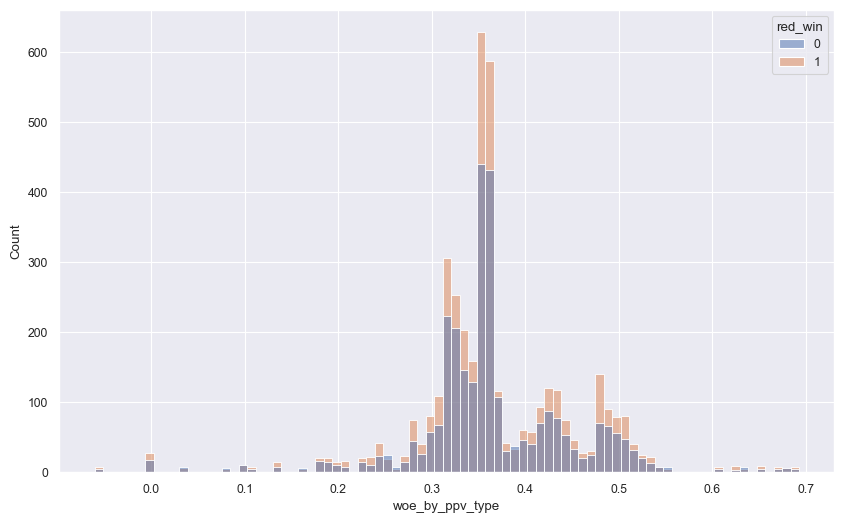

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_theme(style="darkgrid", context="paper")
sns.histplot(df, x="woe_by_ppv_type", hue="red_win", ax=ax)